In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.regression_models import strong_regression_model_factory, weak_regression_model_factory
from utils.tools import generate_data, load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

# Generate Data

In [2]:
generate_data(t=47, subjects=250, random_sample=False)
for i in enumerate(np.linspace(0.5, 12, 47)):
    print(i)

KeyboardInterrupt: 

# Plot Generated Data

In [ ]:
model_data = load_obj('data/regression_bootstrap_data')

df = pd.DataFrame({'yobs':model_data['Yobs'],
                   'y':model_data['y_est'],
                   'times':model_data['times'],
                   'subject_ids':model_data['subject_ids']})

df.loc[:, 'condition'] = False

frames = []
for name, frame in df.groupby('subject_ids'):
#     num = np.random.randint(2, 10)
#     samps = np.random.choice(np.arange(frame.shape[0]), replace = False, size = num)

    samps = np.array([2, 8, 30])
    frame.iloc[samps,-1] = True
    frames.append(frame)
    
df = pd.concat(frames, axis = 0)


condition_on = df.loc[df.condition==True,:]

X = model_data['X']
yobs = condition_on.yobs.values
times = condition_on.times.values
subject_ids = condition_on.subject_ids.values

no_condition = df.loc[df.condition==False, :]

X = model_data['X']
ytest = no_condition.yobs.values
test_times = no_condition.times.values
test_subject_ids = no_condition.subject_ids.values


In [ ]:

g = sns.FacetGrid(data = df.query('subject_ids<25'), col='subject_ids', col_wrap=5)
g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
g.map_dataframe(sns.scatterplot, 'times','yobs', hue = 'condition')


# Strong Priors

In [ ]:
with strong_regression_model_factory(yobs, X, times, test_times, subject_ids, test_subject_ids) as strong_model:
    #Prior Predictive
#     maps = pm.find_MAP(maxeval=50000, options = {'gtol': 1e-8})
    maps = pm.find_MAP(maxeval=10000)
    prior_predictive = pm.sample_prior_predictive(1000)
    #Sample from Posterior
    trace = pm.sample(draws = 1000, 
                      tune = 1000, 
                      chains = 12, 
                      random_seed = 19920908,
                     target_accept = 0.99)
    #Posterior predictrive
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    #Turn into an InferenceData object
    strong_data = az.from_pymc3(prior=prior_predictive, 
                                trace=trace, 
                                posterior_predictive=posterior_predictive,
                                coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})

In [84]:
with strong_model:
    strong_posterior_predictions = pm.sample_posterior_predictive(trace, var_names=['ypred','patient_tmax','Cl'])

100%|██████████| 2000/2000 [00:07<00:00, 259.16it/s]


/Users/demetri/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


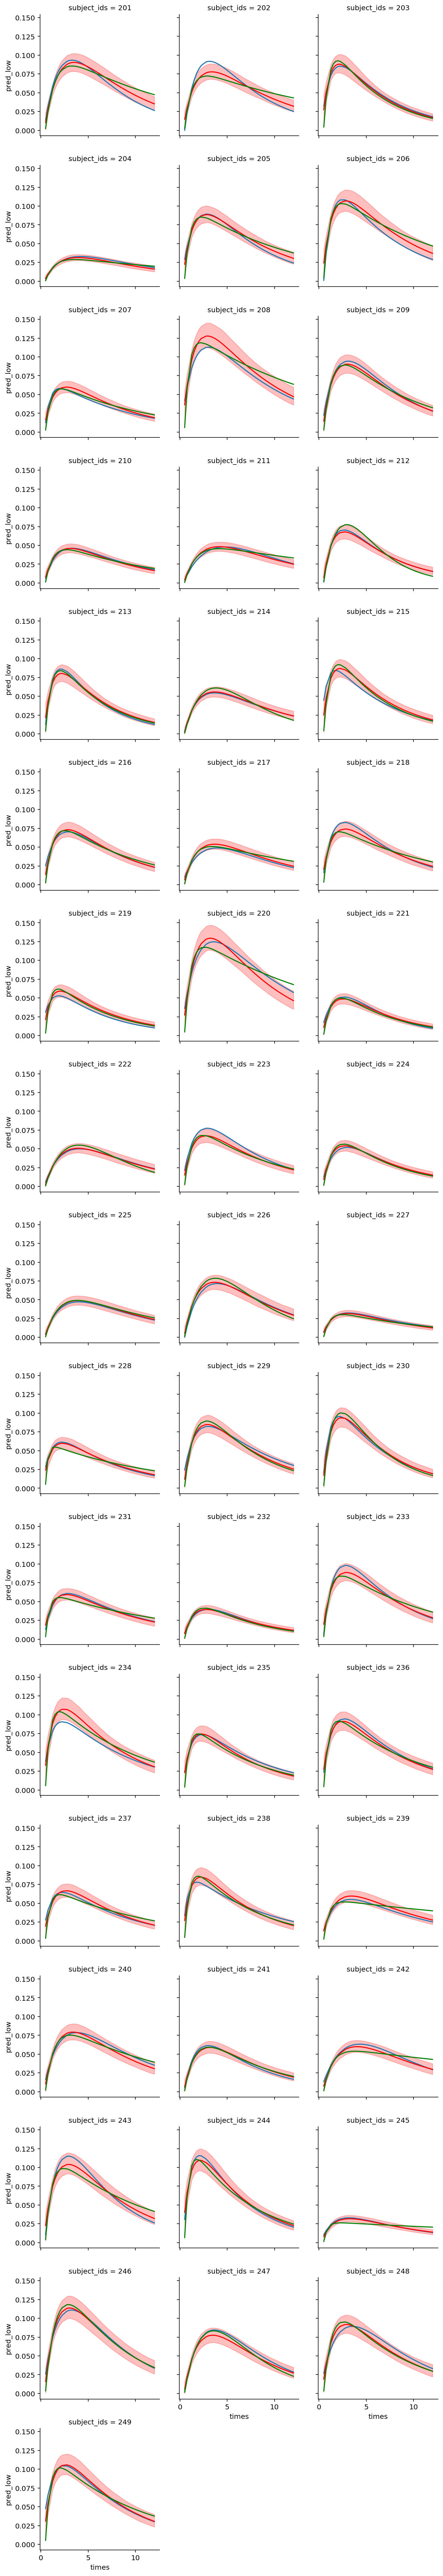

In [101]:
no_condition.loc[:,'pred'] = np.mean(strong_posterior_predictions['ypred'], axis = 0)
no_condition.loc[:,'pred_low'] = np.quantile(strong_posterior_predictions['ypred'], 0.025, axis = 0 )
no_condition.loc[:,'pred_high'] = np.quantile(strong_posterior_predictions['ypred'], 0.975, axis = 0 )
no_condition.loc[:,'map_pred'] = maps['ypred']

g = sns.FacetGrid(data = no_condition.query('subject_ids<500 and subject_ids>200'), col='subject_ids', col_wrap=3)
g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
# g.map_dataframe(sns.scatterplot, 'times','yobs')
g.map_dataframe(sns.lineplot, 'times','pred', estimator = None, color = 'red')
g.map_dataframe(sns.lineplot, 'times','map_pred', estimator = None, color = 'g')

g.map_dataframe(plt.fill_between, 'times', 'pred_low', 'pred_high', alpha = 0.25, color = 'red')

In [96]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(no_condition.y, no_condition.pred))
print(mean_squared_error(no_condition.y, no_condition.map_pred))

1.718894021608879e-05
3.941583138132087e-05


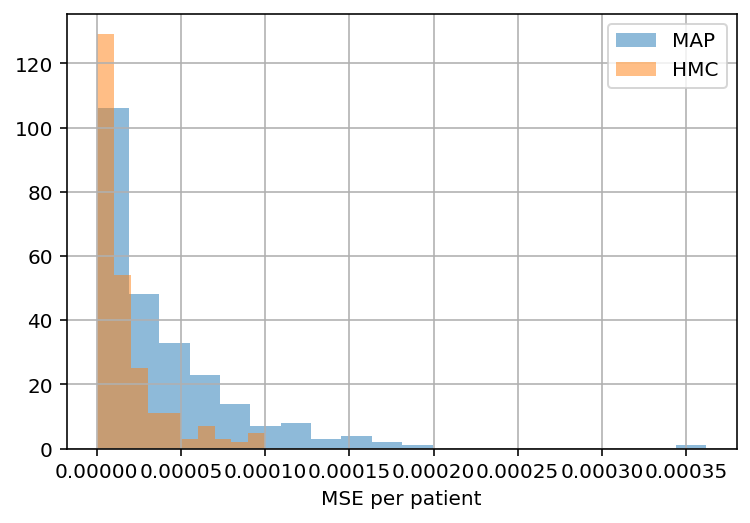

In [97]:
no_condition.groupby('subject_ids').apply(lambda x: mean_squared_error(x.y, x.map_pred)).hist(bins = 20, alpha = 0.5, label = 'MAP')
no_condition.groupby('subject_ids').apply(lambda x: mean_squared_error(x.y, x.pred)).hist(bins = 10, alpha = 0.5, label = 'HMC')
plt.xlabel('MSE per patient')
plt.legend()


In [98]:

maps_tmax = maps['patient_tmax']


In [99]:
hmc_tmax = strong_posterior_predictions['patient_tmax'].mean(axis = 0)

In [100]:
actual_tmax = np.log(model_data['ka']/model_data['ke'])/(model_data['ka'] - model_data['ke'])

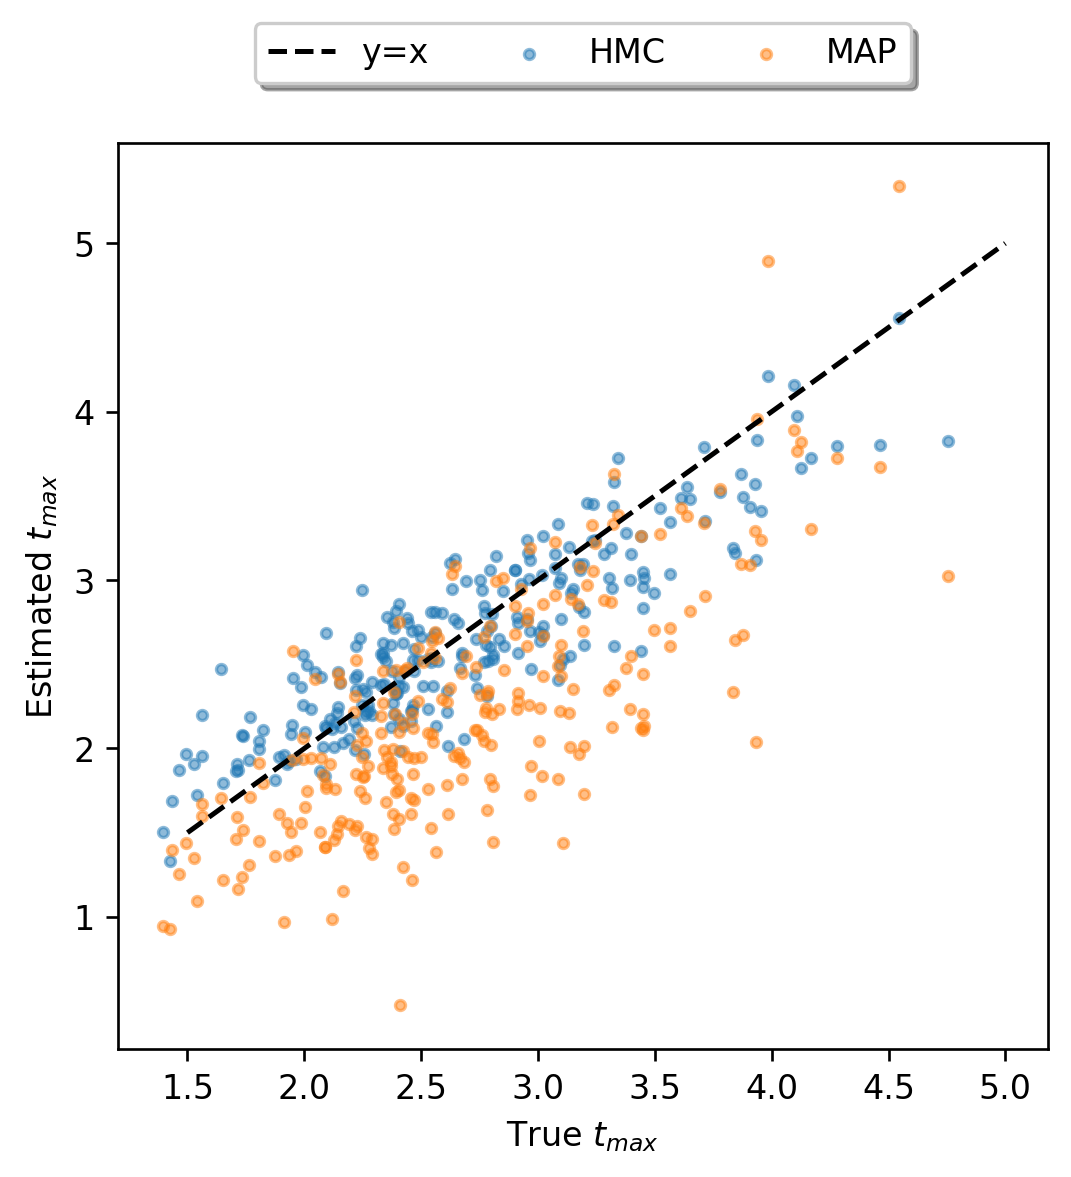

In [91]:

x = np.linspace(1.5, 5, 101)
fig,ax = plt.subplots(dpi = 120, figsize = (5,5))
ax.scatter(actual_tmax, hmc_tmax,marker = '.', alpha = 0.5, label = 'HMC')
ax.scatter(actual_tmax, maps_tmax, marker = '.', alpha = 0.5, label = 'MAP')
ax.plot(x,x,'k--', label = 'y=x')
ax.set_xlabel(r'True $t_{max}$')
ax.set_ylabel(r'Estimated $t_{max}$')
# ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)


plt.savefig('tmax.png', dpi = 400)

In [92]:
mean_squared_error(actual_tmax, maps_tmax)

0.4369431901227089

In [93]:
mean_squared_error(actual_tmax, hmc_tmax)

0.09408654278822055